# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 4 minutes

This notebooks demonstrates the usage of a variant on the [Network Perturbation Amplitude](http://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-6-54) algorithm to analyze an BEL knowledge assembly in the context of a differential gene expression experiment. 

### Notebook Imports

In [1]:
import logging
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from matplotlib_venn import venn2

import pybel
import pybel_tools as pbt
import pybel_tools.analysis.cmpa as cmpa
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
from pybel_tools.visualization import to_jupyter

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packages used are displayed explicitly.

In [3]:
time.asctime()

'Sat Aug 12 19:45:03 2017'

In [4]:
# seed the random number generator
import random
random.seed(127)

In [5]:
pybel.__version__

'0.7.3-dev'

In [6]:
pbt.__version__

'0.1.18-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ['BMS_BASE']

#### OwnCloud

The differential gene expression data used in this notebook is currently not published, and is obfuscated with reference through our team's internal data storage system with [OwnCloud](https://owncloud.org/).

In [8]:
owncloud_base = os.environ['OWNCLOUD_BASE']

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [9]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers', 'alzheimers.gpickle')

In [10]:
graph = pybel.from_pickle(pickle_path)

In [11]:
graph.version

'3.0.9'

All orthologies are discared before analysis.

In [12]:
pbt.filters.remove_nodes_by_namespace(graph, 'MGI')
pbt.filters.remove_nodes_by_namespace(graph, 'RGD')

To merge the differential gene expression annotations, the entire graph is collapsed to genes using [pbt.mutation.collapse_by_central_dogma_to_genes](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.collapse_by_central_dogma_to_genes)

In [13]:
pbt.mutation.collapse_by_central_dogma_to_genes(graph)

pbt.mutation.rewire_variants_to_genes(graph)

In [14]:
pbt.summary.print_summary(graph)

Nodes: 3659
Edges: 20012
Citations: 1753
Authors: 9280
Network density: 0.0014951486863058218
Components: 71
Average degree: 5.4692538945066955
Compilation warnings: 2493


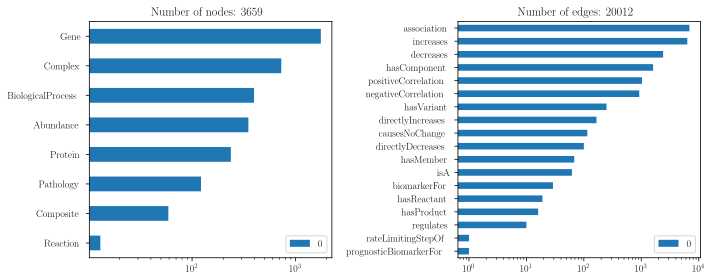

In [15]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

## Differential Gene Expression

Differential gene expression data can be obtained from many sources, including ADNI and other large clinical studies. This analysis is concerned with the log-fold-changes on each gene, and not necessarily the p-value. This is better as a data-driven process becuase it does not require a model or multiple hypothesis testing on raw data.

In [16]:
data_path = os.path.join(owncloud_base, 'alzheimers', 'SevAD.csv')
target_columns = ['Gene.symbol', 'logFC']

In [17]:
df = pd.read_csv(data_path)
df = df.loc[df['Gene.symbol'].notnull(), target_columns]
df.head()

,Gene.symbol,logFC
0,ZNF616,-4.244691
1,DEFB125,3.974393
3,SNAP23,3.337636
4,PHLDB2,3.192559
5,LOC389895,-4.296850


A histogram of the log-fold-changes shows that the data are normally distributed, as expected for differential gene expression data.

In [18]:
# max_fc = {}
# for row, symbol, fc in df.itertuples():
#    if symbol not in max_fc or abs(max_fc[symbol]) < abs(fc):
#        max_fc[symbol] = fc
        
data = {k: v for _, k, v in df.itertuples()}

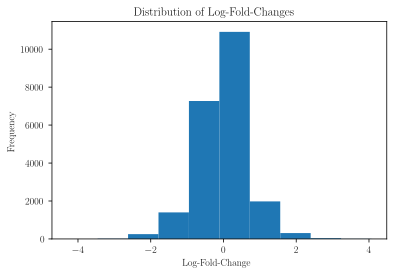

In [19]:
plt.title('Distribution of Log-Fold-Changes')
plt.xlabel('Log-Fold-Change')
plt.ylabel('Frequency')
plt.hist(list(data.values()))
plt.show()

## Overlap Summary

The number of shared elements in the knowledge assembly and differential gene data set are counted.

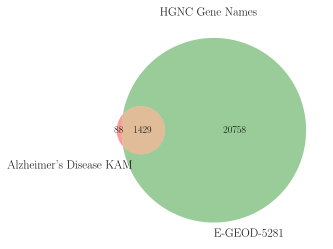

In [20]:
hgnc_names = pbt.summary.get_names_by_namespace(graph, 'HGNC')
df_names = set(df['Gene.symbol'])
overlapping_hgnc_names = hgnc_names & df_names

plt.title('HGNC Gene Names')
venn2([hgnc_names, df_names], set_labels=["Alzheimer's Disease KAM", 'E-GEOD-5281'])
plt.show()

# Analysis

## Data Integration

Finally, the differential gene expression data are ovelayed on the BEL graph with [pbt.integration.overlay_type_data](http://pybel-tools.readthedocs.io/en/latest/integration.html#pybel_tools.integration.overlay_type_data)

In [21]:
label = 'weight'

In [22]:
pbt.integration.overlay_type_data(graph, data, label, GENE, 'HGNC', overwrite=False, impute=0)

## Subgraph Generation

A subgraph is induced around an example biological process, Inflammatory Response, by selecting all of the source nodes of upstream causal edges, where this process is the target node. These networks are then enriched by expandind around all of those nodes' upstream edges as well.

In [23]:
inflamation_node = BIOPROCESS, 'GOBP', 'inflammatory response'

### Iteration 1/2

All of the nodes that have upstream causal relations to Inflammatory Response are added.

In [24]:
subgraph = pbt.mutation.get_upstream_causal_subgraph(graph, inflamation_node)

pbt.summary.print_summary(subgraph)
to_jupyter(subgraph)

Nodes: 40
Edges: 69
Citations: 24
Authors: 164
Network density: 0.04423076923076923
Components: 1
Average degree: 1.725


<IPython.core.display.Javascript object>

### Iteration 2/2

All of the nodes upstream of the nodes within the subgraph are added as well.

In [25]:
pbt.mutation.expand_upstream_causal_subgraph(graph, subgraph)
pbt.summary.print_summary(subgraph)

Nodes: 319
Edges: 1354
Citations: 412
Authors: 2126
Network density: 0.013347528637053687
Components: 1
Average degree: 4.244514106583072


### Post-Processing

Inconsistient edges are thrown away, literature bias is removed, and nodes on the periphery of the subgraph that are not annotated with experimental data are also removed, since they cannot contribute to the propogation of scores.

In [26]:
pbt.mutation.remove_inconsistent_edges(graph)

In [27]:
pbt.mutation.collapse_consistent_edges(graph)

In [28]:
pbt.generation.remove_unweighted_leaves(subgraph, label)

In [29]:
pbt.generation.remove_unweighted_sources(subgraph, label)

In [30]:
pbt.summary.print_summary(subgraph)
to_jupyter(subgraph)

Nodes: 176
Edges: 956
Citations: 325
Authors: 1704
Network density: 0.03103896103896104
Components: 1
Average degree: 5.431818181818182


<IPython.core.display.Javascript object>

This entire procedure can be run automatically with [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism)

## Running

In [31]:
runner = cmpa.Runner(subgraph, inflamation_node, label)

While the algorithm can be immediately run with [pbt.analysis.cmpa.Runner.run](http://pybel-tools.readthedocs.io/en/latest/cmpa.html#pybel_tools.analysis.cmpa.Runner.run), the process is outlined to show the evolution of the graph throughouts its steps. For animation purposes, the functin [pbt.analysis.cmpa.Runner.run_with_graph_transformation](http://pybel-tools.readthedocs.io/en/latest/cmpa.html#pybel_tools.analysis.cmpa.Runner.run_with_graph_transformation) yields a new `BELGraph` at each step through the process as well.

In [32]:
runner.score_leaves()

{('Abundance', 'CHEBI', 'leukotriene'),
 ('Abundance', 'MESHCS', 'Neurofibrillary Tangles'),
 ('Gene', 'HGNC', 'CFH'),
 ('Gene', 'HGNC', 'CHI3L1'),
 ('Gene', 'HGNC', 'IRAK1'),
 ('Gene', 'HGNC', 'IRAK2'),
 ('Gene', 'HGNC', 'PTGS2')}

In [33]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [34]:
runner.score_leaves()

set()

In [35]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [36]:
runner.score_leaves()

set()

In [37]:
runner.remove_random_edge()

to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [38]:
runner.score_leaves()

{('Gene', 'HGNC', 'SCARF1')}

In [39]:
runner.score_leaves()

set()

In [40]:
runner.remove_random_edge()
leaves = runner.score_leaves()
len(leaves)

1

In [41]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [42]:
runner.run()

In [43]:
runner.get_final_score()

266.80520714000187

## Robustness Analysis

The algorithm is random, so it can be run multiple times to assess the robustness of the final scores using [pbt.analysis.cmpa.multirun](http://pybel-tools.readthedocs.io/en/latest/cmpa.html#pybel_tools.analysis.cmpa.multirun)

In [44]:
%%time

runners = list(cmpa.multirun(subgraph, inflamation_node, label, default_score=0, runs=500))

CPU times: user 42.9 s, sys: 636 ms, total: 43.6 s
Wall time: 43.8 s


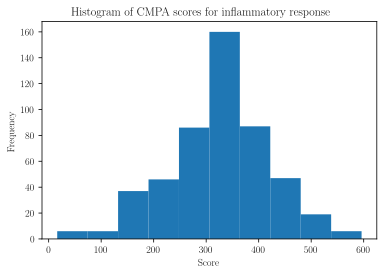

In [45]:
plt.title('Histogram of CMPA scores for {}'.format(calculate_canonical_name(subgraph, inflamation_node)))
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.hist([runner.get_final_score() for runner in runners])
plt.show()

## Full Workflow

This workflow can all be run with [pbt.analysis.cmpa.workflow_all_average](http://pybel-tools.readthedocs.io/en/latest/cmpa.html#pybel_tools.analysis.cmpa.workflow_all_average) but is outlined here for a deeper understanding.

### Generate Candidate Mechanisms

Candidate mechanism are generated with the aforementioned function [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism) to assess the upstream causal subgraphs of all biological processes.

In [46]:
all_bioprocesses = pbt.filters.get_nodes_by_function(graph, BIOPROCESS)

In [47]:
%%time

candidate_mechanisms = {node: pbt.generation.generate_mechanism(graph, node, label) for node in all_bioprocesses}

CPU times: user 580 ms, sys: 13.7 ms, total: 593 ms
Wall time: 594 ms


The algorithm is run over all candidate subgraphs that are nontrivial (have more than one node in them) and a pandas DataFrame is prepared.

In [48]:
%%time

scores = {}

for node, subgraph in candidate_mechanisms.items():
    
    fneighbors = subgraph.in_degree(node)
    fneighbors = 0 if isinstance(fneighbors, dict) else fneighbors
    size = subgraph.number_of_nodes()
    
    if size <= 1:  # Can't calculate a score for empty subgraphs
        average_score = None
    else:
        average_score = cmpa.workflow_average(subgraph, node, label, runs=40)
    
    scores[node] = (average_score, fneighbors, size)

CPU times: user 24.4 s, sys: 174 ms, total: 24.6 s
Wall time: 24.7 s


In [49]:
len(candidate_mechanisms), sum(1 for score, _, _ in scores.values() if score)

(397, 218)

In [50]:
# Optionally, calcualte "cute names" for the nodes
# scores = {calculate_canonical_name(graph, n): s for n, s in scores.items()}

scores_df = pd.DataFrame.from_items(scores.items(), orient='index', columns=['Average CMPA Score','Number First Neighbors','Subgraph Size'])

A scatter matrix is shown below. The distribution of average CMPA scores is shown to be mostly normal. The following scatter plots show small, non-linear relationships between average CMPA score and the subgraph size and the number of first neighbors of the seed node. The trivial positive correlation between number of first neighbors is also shown.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


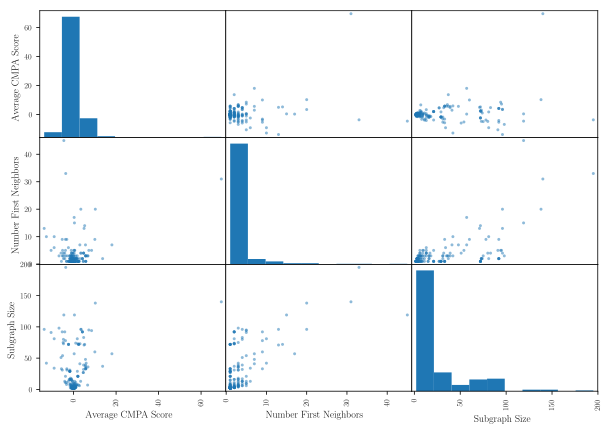

In [51]:
scatter_matrix(scores_df[scores_df['Average CMPA Score'].notnull()], figsize=(10, 7))
plt.show()

In [52]:
scores_df.to_csv(os.path.expanduser('~/Desktop/cmpa_demo.csv'))

In [53]:
scores_df[scores_df['Average CMPA Score'].notnull()].sort_values('Average CMPA Score')

,Average CMPA Score,Number First Neighbors,Subgraph Size
"(BiologicalProcess, GOBP, cell death)",-13.839670,13,96
"(BiologicalProcess, GOBP, production of molecular mediator involved in inflammatory response)",-12.803300,10,42
"(BiologicalProcess, GOBP, chronic inflammatory response)",-10.589999,5,91
"(BiologicalProcess, GOBP, glial cell differentiation)",-9.154514,6,34
"(BiologicalProcess, GOBP, beta-amyloid formation)",-9.133455,10,81
"(BiologicalProcess, GOBP, negative regulation of neuron projection regeneration)",-6.859922,3,98
"(BiologicalProcess, GOBP, regulation of synaptic activity)",-5.916801,4,51
"(BiologicalProcess, GOBP, positive regulation of synaptic transmission, cholinergic)",-5.729107,1,33
"(BiologicalProcess, GOBP, response to oxidative stress)",-5.352444,9,92
"(BiologicalProcess, GOBP, cell-matrix adhesion)",-5.314752,3,31


# Conclusions

## Problems

This algorithm overcomes deterministic problems with cyclic graphs by randomly removing edges. It can be run multiple times to assess the stability of the score with `pbt.analysis.cmpa.average_cmpa_run`. The effect of the default score can also be checked with a grid search.

## Looking Forward

While this new algorithm is generally applicable and overcomes the original algorithm, it must throw away information to do so. Further algorithmic development, such as heat diffusion approaches could allow for a more thorough investigation of the propogation of effects of the differential gene expression.

This algorithm can be run over the mechanisms generated for each biological process. Further investigation into the upstream mechanism generation can yield bias-free candidate mechanisms. They can also be matched to canonical mechanisms in NeuroMMSigDB to identify concordance between the biological dogma and all possible mechanisms, then to identify previously unknown cross-talk between mechanisms.